In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import imp
import sys
sys.path.insert(0,'/home/robin/Projects/sciunit')
sys.path.insert(0,'/home/robin/Projects/INM6/elephant')
sys.path.append('/home/robin/Projects/INM6/python-neo')
# sys.path.append('/home/robin/Projects/simrest_validation')
sys.path.append('/home/robin/Projects/NetworkUnit')
sys.path.append('/home/robin/Projects/INM6/Tasks/')
import sciunit
from viziphant.plots.rasterplot import rasterplot
from elephant.spike_train_surrogates import * 
from elephant.statistics import mean_firing_rate, cv, isi
from validation.matrix import eigenvalue_significance, plot_EVs
from validation.matrix import corr_matrix, plot_matrix, reorder_matrix
from scipy.linalg import eigh
from networkunit import models, tests, scores
from networkunit.plots import alpha
from networkunit.scores import to_precision
import seaborn as sns
from quantities import Hz, ms
from scipy.linalg import eigh
from IPython.core.display import HTML
import urllib2
from time import time
# HTML(urllib2.urlopen('http://bit.ly/1Bf5Hft').read())
rc('text', usetex=True)
font_size = 24
text_size = 26

## Test Network

In [84]:
size = 100
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_HPP = models.stochastic_activity(size=size, correlations=0, assembly_sizes=[],
                                correlation_method='HPP', t_start=tstart, t_stop=tstop,
                                shuffle=False, name='A', color=sns.color_palette('Set2')[2])

## Eigenvalue analysis

In [6]:
cc_matrix = corr_matrix(model_HPP.spiketrains)
EWs, EVs = eigh(cc_matrix)

1.30302349046

Significance Test:
	Method: SCREE 
	3 of 100 eigenvalues are significant

Princial components:
	0: 1.30
	1: 1.29
	2: 1.27



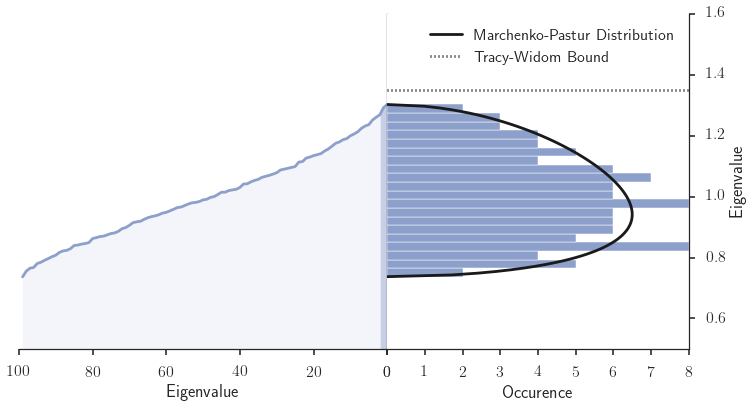

In [4]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,6))

print max(EWs)

eigenvalue_significance(EWs, ax=ax, bins=20, N=size, 
                        B=float((tstop-tstart)/binsize),
                        ylim=(.5, 1.6),
                        color=sns.color_palette('Set2')[2]);

ax.set_xlabel('Eigenvalue \#')

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ew_dist_hpp.png')

## Spectral Norm

In [71]:
from scipy.stats import zscore

trial_num = 1
l_max = np.zeros(trial_num)

for t in range(trial_num):
#     model_HPP = models.stochastic_activity(size=100, correlations=0, assembly_sizes=[],
#                                     correlation_method='HPP', t_start=tstart, t_stop=tstop, rate=10*Hz,
#                                     shuffle=False, name='A', color=sns.color_palette('Set2')[2])

#     cc_matrix = corr_matrix(model_HPP.spiketrains)
    r_mat = np.random.randint(0,2,(100,100))
    for i in range(100):
        r_mat[i] = zscore(r_mat[i]) 
#     r_mat[i] /= np.linalg.norm(r_mat[i])
    cc_matrix = np.dot(r_mat,r_mat.T) / 100.
    np.fill_diagonal(cc_matrix, 1)
    EWs, EVs = eigh(cc_matrix)
    l_max[t] = max(EWs)
    print cc_matrix.shape
    print cc_matrix

(100, 100)
[[ 1.   -0.25 -0.25 ..., -0.17  0.19  0.02]
 [-0.25  1.    0.19 ...,  0.19 -0.19  0.12]
 [-0.25  0.19  1.   ...,  0.19 -0.16 -0.02]
 ..., 
 [-0.17  0.19  0.19 ...,  1.   -0.17 -0.03]
 [ 0.19 -0.19 -0.16 ..., -0.17  1.    0.04]
 [ 0.02  0.12 -0.02 ..., -0.03  0.04  1.  ]]


In [72]:
print max(l_max), min(l_max)
print np.mean(l_max)

19.0420566268 19.0420566268
19.0420566268


## Eigenvectors


In [15]:
from neo.core import SpikeTrain
size = 100
A = 5
cc = .2
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=[A],
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

# test_st = SpikeTrain(np.array(model_cpp.spiketrains[0].tolist())+2, units='ms', 
#                      t_start=tstart, t_stop=tstop)
# model_cpp.spiketrains = model_cpp.spiketrains + [test_st]

In [16]:
cc_matrix = corr_matrix(model_cpp.spiketrains)
EWs, EVs = eigh(cc_matrix)

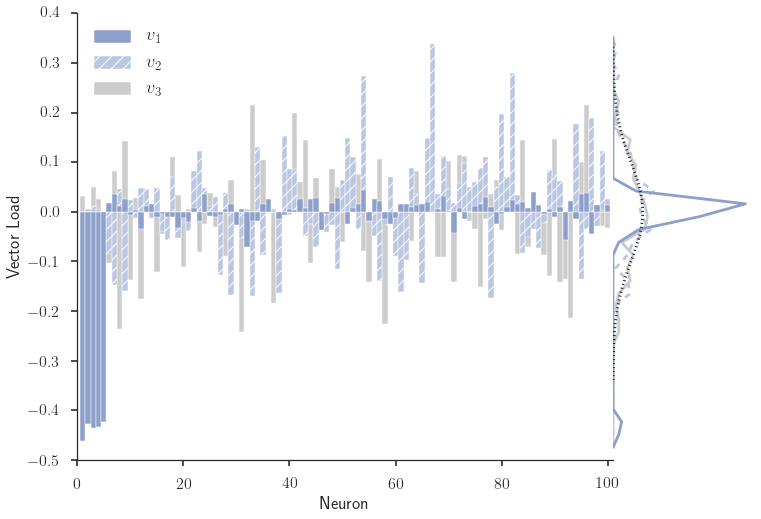

In [17]:
from matplotlib import rc
rc('text', usetex=True)
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,8), sharex=True)
palette = sns.color_palette('Set2')

plot_EVs(EVs, ax, [palette[2], alpha(palette[2],0.6), '0.8'], ['', '//', ''], scaling=.8)

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ev_loads.png')

## Assembly reconstruction

In [74]:
size = 100
A = [5,10,5]
cc = [.4,.3,.2]
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_cpp = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=True)

In [75]:
cpp_mat = corr_matrix(model_cpp.spiketrains, binsize=binsize)

EWs, EVs = eigh(cpp_mat)
order = reorder_matrix(EVs, EWs, alpha=0.001)

19
100


[]

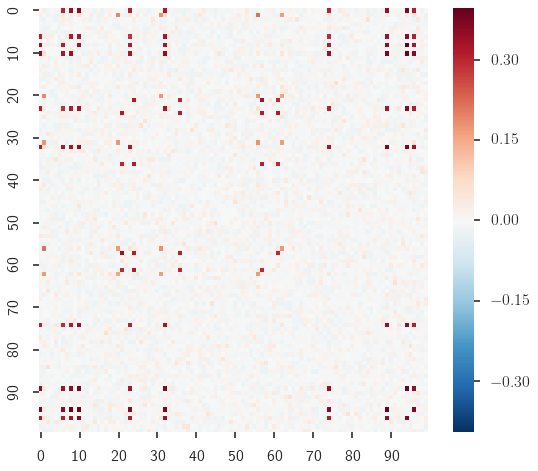

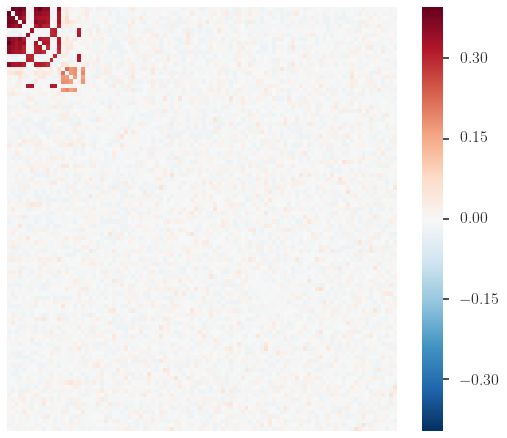

In [76]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

plot_matrix(cpp_mat, ax=ax, remove_autocorr=True)
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ordered_ccmatrix_pre.png')

sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,7))
fig.tight_layout()

plot_matrix(cpp_mat[order,:][:,order], ax=ax, remove_autocorr=True)
ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/ordered_ccmatrix_post.png')

## Angles

In [149]:
size = 100
A = []
cc = .0
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)
model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)

In [153]:
matA = corr_matrix(model_A.spiketrains, binsize=binsize)
matB = corr_matrix(model_B.spiketrains, binsize=binsize)

_, EVs_A = eigh(matA)
_, EVs_B = eigh(matB)

EVs_A = EVs_A.T[::-1]
EVs_B = EVs_B.T[::-1]

flip = True

if flip:
    for count, ev in enumerate(EVsA):
        EVsA[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    for count, ev in enumerate(EVsB):
        EVsB[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    
M = np.dot(EVs_A, EVs_B.T)
ev_angles = [np.arccos(M.flatten())]
# ev_angles = [np.arccos(np.diag(M))]

In [154]:
res = 10000
angles = np.linspace(0,np.pi,res)
dist = np.array([np.sin(a)**(size-2) for a in angles])
dist = dist / (np.sum(dist) * np.pi/res)

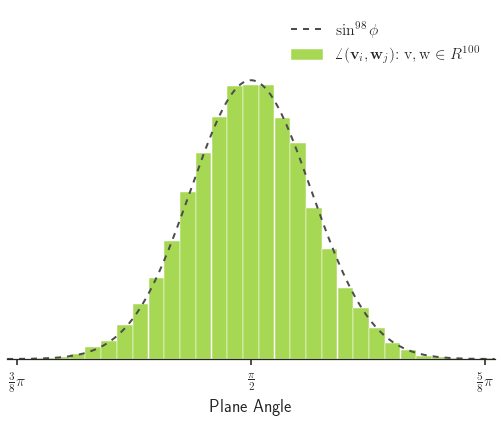

In [155]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))
plt.tight_layout()

ax.plot(angles, dist, color='0.3', lw=2, ls='--', label=r'$\sin^{}\phi$'.format('{'+str(size-2)+'}'))

edges = np.linspace(0,np.pi,120)
hist, _ = np.histogram(ev_angles, bins=edges, density=True)
# hist_diag, _ = np.histogram(ev_angles_diag, bins=edges, density=True)

ax.bar(edges[:-1], hist, np.diff(edges)[0]*.99, color=sns.color_palette()[4], edgecolor='w', 
       label=r'$\angle (\mathbf{v}_i,\mathbf{w}_j)$' + r'$: \mathrm{v},\mathrm{w}\in R^{100}$')
# ax.bar(edges[:-1], hist_diag, np.diff(edges)*.9, color=sns.color_palette()[4], edgecolor='w')


ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1])*np.pi)
ax.set_xticklabels(['', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',
                    r'$\frac{3}{8}\pi$', r'$\frac{\pi}{2}$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'])
ax.set_xlabel(r'Plane Angle')
sns.despine()
if flip:
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_ticks([])
    sns.despine(left=True)

ax.set_ylim((0,5))
frame = np.pi*0.13
ax.set_xlim((np.pi/2.-frame, np.pi/2.+frame))
if flip:
    plt.legend()

sns.despine(left=True)
ax.set_yticks([])
ax.set_yticklabels([''])

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/random_angle_distribution{}.png'\
            .format('_flipped' if flip else ''), bbox_inches='tight')

## Angles as distance measure

In [111]:
size = 100
A = [5,10,5]
cc = [.4,.3,.2]
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms

model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)
model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                correlation_method='CPP', t_start=tstart, t_stop=tstop,
                                shuffle=False)


In [112]:
matA = corr_matrix(model_A.spiketrains, binsize=binsize)
matB = corr_matrix(model_B.spiketrains, binsize=binsize)

_, EVs_A = eigh(matA)
_, EVs_B = eigh(matB)

EVs_A = EVs_A.T[::-1]
EVs_B = EVs_B.T[::-1]

for count, ev in enumerate(EVsA):
    EVsA[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
for count, ev in enumerate(EVsB):
    EVsB[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    
M = np.dot(EVs_A, EVs_B.T)
ev_angles = [np.arccos(M.flatten())]
# ev_angles = [np.arccos(np.diag(M))]

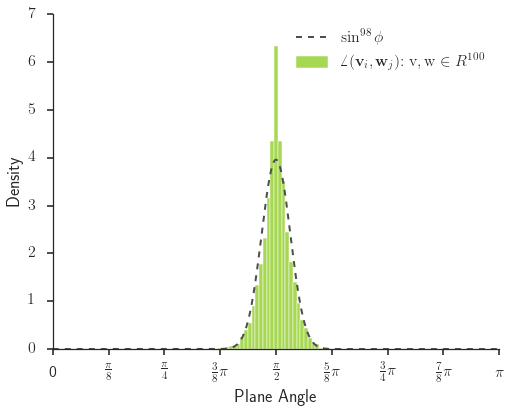

In [147]:
sns.set(style='ticks', palette='Set2', context='poster')
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,6))

ax.plot(angles, dist, color='0.3', lw=2, ls='--', label=r'$\sin^{}\phi$'.format('{'+str(size-2)+'}'))

edges = np.linspace(0,np.pi,120)
hist, _ = np.histogram(ev_angles, bins=edges, density=True)
# hist_diag, _ = np.histogram(ev_angles_diag, bins=edges, density=True)

ax.bar(edges[:-1], hist, np.diff(edges)*.99, color=sns.color_palette()[4], edgecolor='w', 
       label=r'$\angle (\mathbf{v}_i,\mathbf{w}_j)$' + r'$: \mathrm{v},\mathrm{w}\in R^{100}$')
# ax.bar(edges[:-1], hist_diag, np.diff(edges)*.9, color=sns.color_palette()[4], edgecolor='w')


ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1])*np.pi)
ax.set_xticklabels(['0', r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$',
                    r'$\frac{3}{8}\pi$', r'$\frac{\pi}{2}$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'])
ax.set_xlabel(r'Plane Angle')
sns.despine()
ax.set_xlim((0,np.pi))
frame = np.pi*0.13
# ax.set_xlim((np.pi/2.-frame, np.pi/2.+frame))
log = False
if log:
    ax.set_yscale('log')
    ax.set_ylim((0.0001, np.max(hist)))
else:
    ax.set_ylabel('Density', fontweight='bold')
    plt.legend()

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/cluster_angle_distribution{}.png'\
            .format('_log' if log else ''), bbox_inches='tight')

### Weighted Angle Dist

In [3]:
class angle_test(sciunit.TestM2M, tests.correlation_matrix_test):
    score_type = scores.weighted_angle
    params = {'all_to_all': False,
              'two_sided': False,
              'alpha': 0.0001}

    def compute_score(self, prediction1, prediction2):
        score = self.score_type.compute(prediction1, prediction2, **self.params)
        return score

angles = np.array([])

size = 100
A = []
cc = .0
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
B = int(tstop/binsize)

all_to_all = False

In [182]:
sample_angles = np.array([])
wmean_angles = np.array([])
start_time = time()

for i in range(1000):
    model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                    correlation_method='HPP', t_start=tstart, t_stop=tstop,
                                    shuffle=False, name='modelA')
    model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                    correlation_method='HPP', t_start=tstart, t_stop=tstop,
                                    shuffle=False, name='modelB')

    a_test = angle_test()
    EWsA, EVsA = eigh(a_test.generate_prediction(model_A))
    EWsB, EVsB = eigh(a_test.generate_prediction(model_B))
    EWsA = EWsA[::-1]
    EWsB = EWsB[::-1]
    EVsA = EVsA.T[::-1]
    EVsB = EVsB.T[::-1]
    for count, ev in enumerate(EVsA):
        EVsA[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    for count, ev in enumerate(EVsB):
        EVsB[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    M = np.dot(EVsA, EVsB.T)
    M[np.argwhere(M > 1)] = 1.
    if all_to_all:
        angles = np.arccos(M.flatten())
        weights = np.zeros((len(EWsA),len(EWsA)))
        for count1, ew1 in enumerate(EWsA):
            for count2, ew2 in enumerate(EWsB):
                weights[count1,count2] = np.sqrt((ew1**2 + ew2**2)/2.)
        weights = weights.flatten()
        angle_nbr = size**2
    else:
        angles = np.arccos(np.diag(M))
        weights = np.sqrt((EWsA ** 2 + EWsB ** 2) / 2.)
        angle_nbr = size
    weights = weights / sum(weights)
    sample_angles = np.append(sample_angles, angles*weights*angle_nbr)
    wmean_angles = np.append(wmean_angles, np.mean(angles*weights*angle_nbr))
                            
m, s = divmod(time() - start_time, 60)
h, m = divmod(m, 60)
print 'Computation took %d:%02d:%02d' % (h, m, s)

Computation took 1:21:04


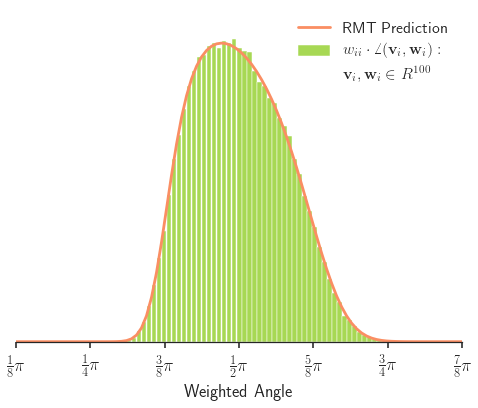

In [183]:
from matplotlib import mlab
sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(figsize=(8,6))

ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1]) * np.pi)
ax.set_xticklabels(['0', r'$\frac{1}{8}\pi$', r'$\frac{1}{4}\pi$',
                    r'$\frac{3}{8}\pi$', r'$\frac{1}{2}\pi$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'], fontsize=18)

ax.set_xlabel(r'Weighted Angle$')
#               + r'$^{}$'.format('{' + str(size) + '}'), fontsize=20)

edges = np.linspace(0, np.pi, 120)
hist, _ = np.histogram(sample_angles/sum(weights), bins=edges, density=True)

if all_to_all:
    label = [r'$w_{ij}\cdot\angle (\mathbf{v}_i,\mathbf{w}_j):$', '$\mathbf{v}_i,\mathbf{w}_j \in R^{100}$']
else:
    label = [r'$w_{ii}\cdot\angle (\mathbf{v}_i,\mathbf{w}_i):$', '$\mathbf{v}_i,\mathbf{w}_i \in R^{100}$']
ax.bar(edges[:-1], hist, np.diff(edges)[0] * .99,
       color=sns.color_palette('Set2')[4], edgecolor='w',
       label='{}'.format(label[0]))
ax.bar([.1,.1],[0.1,0.1], color='w', edgecolor='w', 
       label='{}'.format(label[1]))

x = np.linspace(0, np.pi, 120)
y = scores.weighted_angle.weighted_angle_distribution(x, size, B=5000, use_gaus=all_to_all)
norm = np.sum(y) * (x[1] - x[0])
ax.plot(x, np.array(y) / norm, color=sns.color_palette('Set2')[1], label='RMT Prediction')

ax.set_xlim((0.125*np.pi,0.875*np.pi))
ax.set_yticks([])
plt.legend()

sns.despine(left=True)
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/weighted_angle_distribution{}.png'
#             .format('_all_to_all' if all_to_all else ''), 
#             bbox_inches='tight')

plt.show()

In [7]:
import scipy.interpolate as interpolate

x = np.linspace(0, np.pi, 120)
y = scores.weighted_angle.weighted_angle_distribution(x, size, B=5000, use_gaus=all_to_all)
norm = np.sum(y) * (x[1] - x[0])
y = y / norm

def inverse_transform_sampling(x, y, n_samples=1000):
    x = x + np.diff(x)[0]/2.
    x = np.append(np.array([0]),x)
    cum_values = np.zeros(len(x))
    cum_values[1:] = np.cumsum(y*np.diff(x))
    inv_cdf = interpolate.interp1d(cum_values, x)
    r = np.random.rand(n_samples)
    return inv_cdf(r)

sample_std = np.std(inverse_transform_sampling(x,y,n_samples=10**6))
print sample_std
print np.std(sample_angles)

0.183866692765
0.196394346162


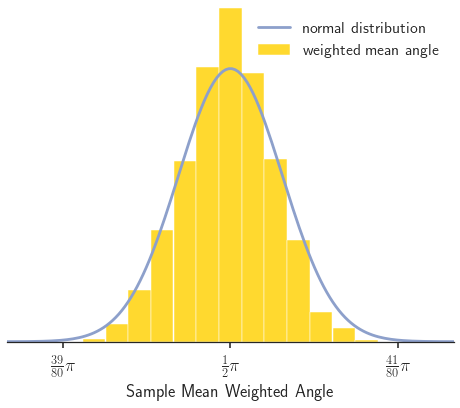

In [186]:
import matplotlib.mlab as mlab
sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(figsize=(8,6))

ax.set_xlabel(r'Sample Mean Weighted Angle')
#               + r'$^{}$'.format('{' + str(size) + '}'), fontsize=20)

edges = np.linspace(np.pi/2.-np.pi/20., np.pi/2.+np.pi/20., 60)
hist, _ = np.histogram(wmean_angles, bins=edges, density=True)

ax.bar(edges[:-1], hist, np.diff(edges)[0] * .99,
       color=sns.color_palette('Set2')[5], edgecolor='w',
       label=r'weighted mean angle')

if all_to_all:
    angle_nbr = size**2
else:
    angle_nbr = size

mu = np.pi/2.
sample_factor = 2.* np.sqrt(angle_nbr)
sigma = sample_std/sample_factor
x = np.linspace(np.pi/2-np.pi/(2.*sample_factor), np.pi/2.+np.pi/(2.*sample_factor), 220)
ax.plot(x,mlab.normpdf(x, mu, sigma), color=sns.color_palette('Set2')[2], 
        label=r'normal distribution')

# ax.set_xticks(np.array([0.49875, .5, .50125]) * np.pi)
# ax.set_xticklabels([r'$\frac{399}{800}\pi$', r'$\frac{1}{2}\pi$',
#                     r'$\frac{401}{800}\pi$'], fontsize=18)
# ax.set_xlim((np.pi/2.-np.pi/600., np.pi/2.+np.pi/600.))

ax.set_xticks(np.array([0.4875, .5, .5125]) * np.pi)
ax.set_xticklabels([r'$\frac{39}{80}\pi$', r'$\frac{1}{2}\pi$',
                    r'$\frac{41}{80}\pi$'], fontsize=18)
ax.set_xlim((np.pi/2.-np.pi/60., np.pi/2.+np.pi/60.))

ax.set_yticks([])
ax.set_yticklabels([''])

plt.legend()
sns.despine(left=True)

# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/mean_weighted_angle_distribution{}.png'
#             .format('_all_to_all' if all_to_all else ''), 
#             bbox_inches='tight')
plt.show()

### Test Demonstration HOC/PWC

In [31]:
size = 100
A = [10,3,2,2]
cc = [.4,.3,.3,.2]
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
all_to_all = True
corr_method = 'pairwise_equivalent' #'CPP'

model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                    correlation_method=corr_method, t_start=tstart, t_stop=tstop,
                                    shuffle=False, name='modelA')
model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                    correlation_method=corr_method, t_start=tstart, t_stop=tstop,
                                    shuffle=False, name='modelB')

a_test = angle_test()
EWsA, EVsA = eigh(a_test.generate_prediction(model_A))
EWsB, EVsB = eigh(a_test.generate_prediction(model_B))
EWsA = EWsA[::-1]
EWsB = EWsB[::-1]
EVsA = EVsA.T[::-1]
EVsB = EVsB.T[::-1]

for count, ev in enumerate(EVsA):
    EVsA[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
for count, ev in enumerate(EVsB):
    EVsB[count] = ev * np.sign(ev[np.argmax(np.absolute(ev))])
    
M = np.dot(EVsA, EVsB.T)
M[np.argwhere(M > 1)] = 1.
if all_to_all:
    angles = np.arccos(M.flatten())
    weights = np.zeros((len(EWsA),len(EWsA)))
    for count1, ew1 in enumerate(EWsA):
        for count2, ew2 in enumerate(EWsB):
            weights[count1,count2] = np.sqrt((ew1**2 + ew2**2)/2.)
    weights = weights.flatten()
    angle_nbr = size**2
else:
    angles = np.arccos(np.diag(M))
    weights = np.sqrt((EWsA ** 2 + EWsB ** 2) / 2.)
    angle_nbr = size
weights = weights / sum(weights)
sample_angles = angles*weights*angle_nbr

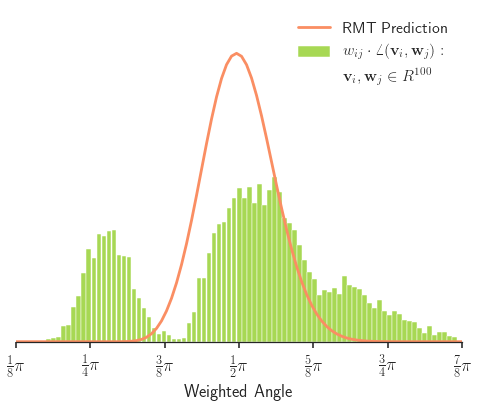

In [ ]:
from matplotlib import mlab
sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(figsize=(8,6))

ax.set_xticks(np.array([0, 0.125, .25, .375, .5, .625, .75, .875, 1]) * np.pi)
ax.set_xticklabels(['0', r'$\frac{1}{8}\pi$', r'$\frac{1}{4}\pi$',
                    r'$\frac{3}{8}\pi$', r'$\frac{1}{2}\pi$',
                    r'$\frac{5}{8}\pi$', r'$\frac{3}{4}\pi$',
                    r'$\frac{7}{8}\pi$', r'$\pi$'], fontsize=18)

ax.set_xlabel(r'Weighted Angle$')

edges = np.linspace(0, np.pi, 120)
hist, _ = np.histogram(sample_angles, bins=edges, density=True)

if all_to_all:
    label = [r'$w_{ij}\cdot\angle (\mathbf{v}_i,\mathbf{w}_j):$', '$\mathbf{v}_i,\mathbf{w}_j \in R^{100}$']
else:
    label = [r'$w_{ii}\cdot\angle (\mathbf{v}_i,\mathbf{w}_i):$', '$\mathbf{v}_i,\mathbf{w}_i \in R^{100}$']
ax.bar(edges[:-1], hist, np.diff(edges)[0] * .99,
       color=sns.color_palette('Set2')[4], edgecolor='w',
       label='{}'.format(label[0]))
ax.bar([0],[0], width=0, color='w', edgecolor='w', 
       label='{}'.format(label[1]))

x = np.linspace(0, np.pi, 120)
y = scores.weighted_angle.weighted_angle_distribution(x, size, B=5000, use_gaus=all_to_all)
norm = np.sum(y) * (x[1] - x[0])
ax.plot(x, np.array(y) / norm, color=sns.color_palette('Set2')[1], label='RMT Prediction')

ax.set_xlim((0.125*np.pi,0.875*np.pi))
ax.set_yticks([])
plt.legend()

sns.despine(left=True)
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/weighted_angle_example{}{}.png'
            .format('_all_to_all' if all_to_all else '', corr_method), 
            bbox_inches='tight')

plt.show()

0.183748652617
0.475714560001


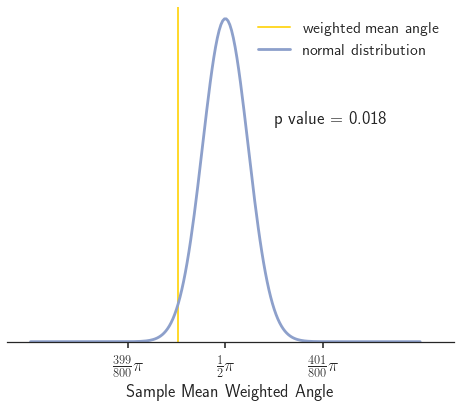

In [33]:
import matplotlib.mlab as mlab
from scipy.integrate import quad

x = np.linspace(0, np.pi, 120)
y = scores.weighted_angle.weighted_angle_distribution(x, size, B=5000, use_gaus=all_to_all)
norm = np.sum(y) * (x[1] - x[0])
y = y / norm
sample_std = np.std(inverse_transform_sampling(x,y,n_samples=10**6))
print sample_std
print np.std(sample_angles)

sns.set(context='poster', style='ticks', palette='Set2')
fig, ax = plt.subplots(figsize=(8,6))

ax.set_xlabel(r'Sample Mean Weighted Angle')
#               + r'$^{}$'.format('{' + str(size) + '}'), fontsize=20)

ax.axvline(np.mean(sample_angles), color=sns.color_palette('Set2')[5], 
           lw=2, label='weighted mean angle')

if all_to_all:
    angle_nbr = size**2
else:
    angle_nbr = size

mu = np.pi/2.
sample_factor = 2.* np.sqrt(angle_nbr)
sigma = sample_std/sample_factor
x = np.linspace(np.pi/2-np.pi/(2.*sample_factor), np.pi/2.+np.pi/(2.*sample_factor), 220)
ax.plot(x,mlab.normpdf(x, mu, sigma), color=sns.color_palette('Set2')[2], 
        label=r'normal distribution')

p_integral = quad(mlab.normpdf, 0., np.mean(sample_angles), args=(mu,sigma))

if all_to_all:
    ax.set_xticks(np.array([0.49875, .5, .50125]) * np.pi)
    ax.set_xticklabels([r'$\frac{399}{800}\pi$', r'$\frac{1}{2}\pi$',
                        r'$\frac{401}{800}\pi$'], fontsize=18)
    # ax.set_xlim((np.pi/2.-np.pi/600., np.pi/2.+np.pi/600.))
else:
    ax.set_xticks(np.array([0.4875, .5, .5125]) * np.pi)
    ax.set_xticklabels([r'$\frac{39}{80}\pi$', r'$\frac{1}{2}\pi$',
                        r'$\frac{41}{80}\pi$'], fontsize=18)
    ax.set_xlim((np.pi/2.-np.pi/30., np.pi/2.+np.pi/30.))

ax.text(.6, .65, 'p value = ' + '{}'.format(to_precision(p_integral[0],2)), 
        fontsize=18, transform=ax.transAxes)

ax.set_yticks([])
ax.set_yticklabels([''])

plt.legend()
sns.despine(left=True)

plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/mean_weighted_angle_example{}{}.png'
            .format('_all_to_all' if all_to_all else '',corr_method), 
            bbox_inches='tight')
plt.show()

## Parameter Scan

In [4]:
class angle_test(tests.correlation_matrix_test, tests.model2model_test):
    score_type = scores.weighted_angle
    params = {'all_to_all': True,
              'two_sided': False,
              'alpha': 0.0001,
              'binsize': 2*ms,
              'bin_num': 5000}

    def compute_score(self, prediction1, prediction2):
        score = self.score_type.compute(prediction1, prediction2, **self.params)
        return score

size = 100
rate = 10*Hz
tstart = 0*ms
tstop = 10000*ms
binsize = 2*ms
B = int(tstop/binsize)
angle_score = [0] * 99
count = 0

In [44]:
start_time = time()
for A in [[2],[3],[4],[5],[6],[7],[8],[9],[10]]:
    for cc in [0,.1,.2,.3,.4,.5,.6,.7,.8,.9, 1.]:
        temp_p = np.zeros(10)
        for repeat in range(10):
            model_A = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                                correlation_method='pairwise_equivalent', t_start=tstart, t_stop=tstop,
                                                shuffle=False, name='A')
            model_B = models.stochastic_activity(size=size, correlations=cc, assembly_sizes=A,
                                                correlation_method='pairwise_equivalent', t_start=tstart, t_stop=tstop,
                                                shuffle=False, name='B')
            test = angle_test(model_A)
            score = test.judge(model_B)
            temp_p[repeat] = score.pvalue
        
        m, s = divmod(time() - start_time, 60)
        h, m = divmod(m, 60)
        print 'time %d:%02d:%02d' % (h, m, s)
        angle_score[count] = (np.mean(temp_p), np.std(temp_p))
        print 'A: ', A, ' cc: ', cc
        print angle_score[count]
        count = count + 1

time 0:00:55
A:  [2]  cc:  0
(0.37084114029300858, 0.22651928999179627)
time 0:01:57
A:  [2]  cc:  0.1
(0.33535069622367686, 0.29209039916327617)
time 0:03:00
A:  [2]  cc:  0.2
(0.24380629980583302, 0.22662866931109452)
time 0:04:05
A:  [2]  cc:  0.3
(0.29244059540586853, 0.31733151770085399)
time 0:05:04
A:  [2]  cc:  0.4
(0.27247494598679312, 0.33308970068214133)
time 0:06:28
A:  [2]  cc:  0.5
(0.19784950047123839, 0.21512012476049705)
time 0:07:26
A:  [2]  cc:  0.6
(0.27376556500512805, 0.30159511503478459)
time 0:08:36
A:  [2]  cc:  0.7
(0.27515668812632821, 0.29611626079689779)
time 0:09:41
A:  [2]  cc:  0.8
(0.29559426056588967, 0.30773890961604516)
time 0:10:53
A:  [2]  cc:  0.9
(0.34963443124205773, 0.30411425061105019)
time 0:12:11
A:  [2]  cc:  1.0
(0.043526307136489847, 0.084802384711492693)
time 0:13:24
A:  [3]  cc:  0
(0.19587223398440451, 0.2351713098707684)
time 0:14:36
A:  [3]  cc:  0.1
(0.26147217778196574, 0.2788941099326373)
time 0:15:48
A:  [3]  cc:  0.2
(0.14823885

IndexError: list assignment index out of range

In [34]:
one2one_score = [(0.36515108544895669, 0.28519844429758318), (0.54851045870369353, 0.19426935172973189), (0.28955918402263697, 0.24965900911881378), (0.20659746499782389, 0.18571213424690639), (0.2093053646792625, 0.19809888606313794), (0.16558865538712753, 0.16668339047506317), (0.048605253183279566, 0.059185156814437596), (0.10622474834209691, 0.09156661699216842), (0.036966298187457378, 0.033407336905126567), (0.056266895949757777, 0.078403751537883093), (0.05489286760284149, 0.096374430195681232), (0.46679844614964316, 0.18103610842774054), (0.26279907839379274, 0.25049959141414258), (0.23406046612979239, 0.20112436252391364), (0.084502295885681228, 0.11984985186485254), (0.065285403940612316, 0.078481227547690907), (0.043153165793153897, 0.095413821532174176), (0.025687228819599766, 0.019896301182271276), (0.026444073963876304, 0.03609217866541875), (0.00095306425235996744, 0.0015620441211451888), (0.021041828111060899, 0.038954341310934011), (0.003661544327515811, 0.0063606871117332861), (0.44355219611150476, 0.22837589787780316), (0.20488144062694952, 0.17453188786032314), (0.08373963902244605, 0.13451614200634276), (0.071373992127979541, 0.095985891241064158), (0.040769824624453228, 0.089702455358021044), (0.020097236224841414, 0.023517273640683126), (0.014794124350868011, 0.039410059633892471), (0.0035059936611995558, 0.006302832357958631), (0.00019320372894441522, 0.00044020473196513258), (0.0002481314605785599, 0.00052085951278819844), (3.6623285738402176e-06, 7.0220947611440863e-06), (0.45145402155204895, 0.18360895179616266), (0.23696831022570147, 0.22198434369035783), (0.044715631972535738, 0.033240949826012847), (0.005769743608754656, 0.013513467661680319), (0.017505536208282237, 0.034969445682963667), (0.00031222441224207961, 0.00062677370553817472), (0.002051925086684574, 0.003290047819327496), (1.8248785916989659e-05, 2.8188504361216401e-05), (4.6084529097752749e-07, 1.1697415004732661e-06), (3.1756549339651981e-06, 9.3862899358057238e-06), (1.4902631062512531e-05, 3.9592737507868432e-05), (0.24299756396713718, 0.22028677558249574), (0.19911817216238817, 0.21187936184615624), (0.017638708825371729, 0.030146616598536187), (0.0041237299169513868, 0.0064961130503585242), (0.0068501555262390811, 0.015026786601720344), (9.5791780769181057e-05, 0.0001980563768792206), (0.00010004629057180624, 0.00026912133613257001), (2.3322371088060743e-05, 6.1239601295996014e-05), (3.1333997475597551e-07, 8.3153032858919189e-07), (1.3289595515593543e-08, 3.9083324532206832e-08), (3.2978364887089639e-09, 6.8190796263430161e-09), (0.4295958792125491, 0.26201814790803357), (0.032069466267977541, 0.037902484131968457), (0.028911384243815081, 0.065040634202643804), (0.030811041839389385, 0.08359998427700939), (0.00020851705627810882, 0.00037212953834935166), (0.0013396823050653664, 0.003811818307099766), (8.4985736872138286e-07, 1.6999954162644015e-06), (4.1260447464124272e-08, 8.4490181690367023e-08), (1.4853838536435657e-09, 4.392528757398207e-09), (2.0153971451997381e-12, 5.2890641030473815e-12), (1.3744785969063278e-14, 3.9965074026708321e-14), (0.45900690482787931, 0.26402658369321647), (0.071318686483454186, 0.064058745259429117), (0.028954466000576301, 0.040065844490287036), (0.01007802454086934, 0.028007199937047249), (4.6161612341970445e-05, 8.6779413694794015e-05), (3.1315091937338162e-06, 5.3964851125759851e-06), (2.3057750762405419e-08, 6.9117363262631541e-08), (6.801492775314335e-12, 1.0843345830113934e-11), (1.3706239069226448e-12, 3.4559409715840584e-12), (4.1207188724988749e-17, 8.8685339383580175e-17), (4.853971118887452e-16, 1.4550663155272814e-15), (0.4700868080780024, 0.31882113367661108), (0.098133341108626509, 0.15974699293398237), (0.015391247383854062, 0.030445572144765908), (0.0004255475615160675, 0.00068637353938486869), (0.00013848208133573651, 0.000411764647167285), (1.0570425539775466e-07, 3.0620507549337193e-07), (1.0166977531249121e-10, 2.5254935595514617e-10), (7.9716212365575135e-13, 2.327129989545154e-12), (4.4872667477223186e-15, 1.2693171441072557e-14), (1.7901076399203362e-18, 5.1068855108321136e-18), (1.0440193076943879e-22, 3.0451215327859924e-22), (0.38650947839813921, 0.25838870319512608), (0.024095597744015689, 0.019046922059578385), (0.0012280653212727579, 0.0014788749296959153), (0.00013499430182739694, 0.00032030897978974787), (3.7207965315509178e-07, 4.102973726550522e-07), (4.5827758756764819e-08, 1.3255635022140042e-07), (3.3957776083817579e-12, 1.0015537446312929e-11), (1.1056137706152651e-16, 3.2993096126671359e-16), (2.2782011820940788e-18, 5.9163353613637567e-18), (4.6539545146785105e-23, 1.3961845045108647e-22), (5.2193969510188503e-28, 1.5619942113130131e-27)]
all2all_score = [(0.30458231544939157, 0.22763303989467845), (0.31445619892449678, 0.20688855412071028), (0.37366537116943099, 0.30266804689396287), (0.30089669715372797, 0.22967603731919442), (0.35525082555784993, 0.24288105684614031), (0.20986743372617758, 0.16149348318859974), (0.33601721387496508, 0.29133392731103402), (0.13368503042162794, 0.13646104263339001), (0.18539048083356899, 0.25098744131919865), (0.1764892557514135, 0.19037820182712806), (0.18914592573283173, 0.21459960959287008), (0.27754555184280022, 0.27820719720913306), (0.40834898906250949, 0.31594026811077786), (0.3661204016225863, 0.33100849854107534), (0.175728257284089, 0.19198648666555471), (0.20941166095566666, 0.19842834058330161), (0.12353767214637083, 0.17550447856993373), (0.16534906554730172, 0.1675659465091292), (0.082907559299409878, 0.10928285822435915), (0.093904566787588656, 0.1530522528174964), (0.099220811285352317, 0.095911395816081782), (0.16432039492579473, 0.1328059100908224), (0.21863488311854579, 0.26324422242420498), (0.25500407000998465, 0.29364293834784383), (0.2034591931442648, 0.26922549116711414), (0.21002548310297436, 0.20350246486554244), (0.30826688509496403, 0.3056595396664869), (0.19171483731670219, 0.19044988716908504), (0.15663455053391478, 0.16152078288377922), (0.21055843282350031, 0.23636518217444769), (0.24111018779047416, 0.25742404902036858), (0.14614012050502984, 0.18306177340116125), (0.14343445211076256, 0.21752361145774171), (0.18295134346042988, 0.16976541779219984), (0.34154394052816839, 0.31104463323896009), (0.1736345368991572, 0.21897788845627794), (0.14790237227236996, 0.12271454949523436), (0.19487817618842002, 0.24047619520829441), (0.20953445505612484, 0.2593077072458248), (0.23552178842697588, 0.19999223672730512), (0.078473379681822553, 0.098274533458974966), (0.14473780376404757, 0.10477997708598845), (0.16892966268999404, 0.18521201200597201), (0.18723040311011796, 0.23216521628904266), (0.26699927593442185, 0.23879845764369714), (0.12361769168489305, 0.16681396106666577), (0.1268573846645436, 0.11404439711489575), (0.21702005176047598, 0.23440056115635244), (0.13391454607522973, 0.17632745103403846), (0.14985089678507596, 0.14648105265793923), (0.18050181587521485, 0.23158407053006208), (0.073183374330286863, 0.073664262175896791), (0.12480149685124146, 0.18854860857104652), (0.14230942585353087, 0.20987245422901196), (0.1329951251179447, 0.20180832491804399), (0.26486612078483424, 0.27328794906919007), (0.45724589449795, 0.32426437173994099), (0.34718264926969084, 0.23080256757059273), (0.20266544742124654, 0.1812588763282498), (0.15435013766913602, 0.1415054098402615), (0.17207536138480981, 0.18856123431242994), (0.089130846924354967, 0.11505619269869193), (0.12530966114431971, 0.10444549152642348), (0.1205235542645066, 0.16954225865564945), (0.096448775323415392, 0.10476838074692368), (0.070577429336992001, 0.066584981373594379), (0.25601928805545693, 0.21358721013349713), (0.10528856904182497, 0.0662638014618359), (0.24853423673909644, 0.30172825164919354), (0.29419940307533909, 0.30112481253129081), (0.11360085169613957, 0.11884770385608073), (0.16167813085455945, 0.27026623707470399), (0.22377221282530541, 0.19102061919719832), (0.10773559321670594, 0.21667213477596498), (0.063289569420236225, 0.075564552268822416), (0.10093801397334937, 0.17403118202251777), (0.079042976173621368, 0.12812198965514468), (0.26015835504348811, 0.23546706962089084), (0.30837559556872113, 0.29062111623029124), (0.24350795798137467, 0.29091399439097143), (0.26405559083213659, 0.23594669764553541), (0.13245605191766521, 0.17287191283027492), (0.19252790381013812, 0.199179493099264), (0.16899800558126882, 0.16135983865102932), (0.022078860623594054, 0.030241175638940049), (0.20119022549279575, 0.18592772640254218), (0.10558508180049739, 0.13179948254747528), (0.057184121979680272, 0.08697401329974358), (0.24744219647245461, 0.27025494298512631), (0.18746133389370848, 0.20322337215618394), (0.1993647370301336, 0.22066887895545836), (0.35833163336889612, 0.27194662942241865), (0.085124854673520461, 0.11604841925309951), (0.10372177746460139, 0.13423302285807015), (0.078554535130518521, 0.092088353327829053), (0.055913208174448926, 0.083660312771253506), (0.13739720912417228, 0.14480581999957859), (0.033202406678519619, 0.049993385595991771), (0.11919904729765363, 0.1661337624163598)]

ValueError: x and y must have same first dimension

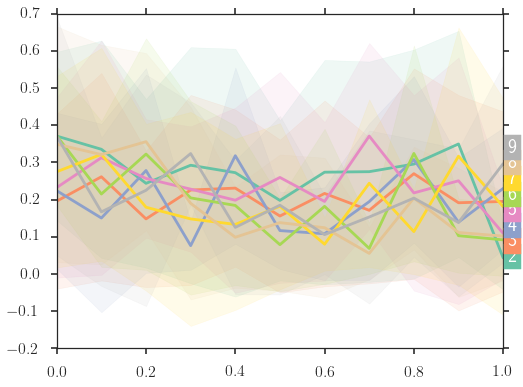

In [7]:
sns.set(palette=sns.color_palette("Set2", 8)+[(0.4,0.4,0.4)], style='ticks', context='poster')
fig, ax = plt.subplots(figsize=(8,6))
rho = [0,.1,.2,.3,.4,.5,.6,.7,.8,.9,1.]
pvalues = [a[0] for a in angle_score]
std_min = [a[0]-a[1] for a in angle_score]
std_max = [a[0]+a[1] for a in angle_score]

for count, A in enumerate([2,3,4,5,6,7,8,9,10]):
    curr_handle, = ax.plot(rho, pvalues[count*11:count*11+11])
    ax.fill_between(rho, std_min[count*11:count*11+11], 
                    std_max[count*11:count*11+11], color=curr_handle.get_color(), 
                    alpha=0.1)
    ax.text(1.01, .42/10.*A-.05,
                        '{}'.format(A),
                        fontweight='bold',
                        backgroundcolor=curr_handle.get_color(),
                        color='w')

ax.set_xlabel(r'$\rho$')
ax.set_ylabel('p value')
ax.set_ylim((0,.55))
ax.grid()
sns.despine()
# plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/weighted_angle_param_scan_all_to_all.png', bbox_inches='tight')

In [3]:
from pypet import Trajectory
import numpy as np
from os import listdir
from os.path import expanduser
from h5py import File
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

data_path = '/home/robin/Projects/pop_cch_results/'
filename = '9A_13rho_result.h5'

traj = Trajectory(filename=data_path + filename)
traj.f_load(index=-1, load_parameters=0,
            load_results=2, force=True)
traj.v_auto_load = True

assembly_sizes = [[2], [3], [4], [5], [6], [7], [8], [9], [10]]
correlations = [.0, .05, .1, .15, .2, .3, .4, .5, .6, .7, .8, .9, 1.]

cpp_cpp_o2o = np.zeros((len(assembly_sizes),len(correlations),2))
cpp_cpp_a2a = np.zeros((len(assembly_sizes),len(correlations),2))

pwc_pwc_o2o = np.zeros((len(assembly_sizes),len(correlations),2))
pwc_pwc_a2a = np.zeros((len(assembly_sizes),len(correlations),2))

cpp_pwc_o2o = np.zeros((len(assembly_sizes),len(correlations),2))
cpp_pwc_a2a = np.zeros((len(assembly_sizes),len(correlations),2))

for A_count, A in enumerate(assembly_sizes):
    for cc_count, cc in enumerate(correlations):
        run_count = A_count * len(correlations) + cc_count
        run = traj.results['run_{:08d}'.format(run_count)]

        cpp_cpp_o2o[A_count][cc_count][0] = run['cpp_cpp_o2o_mean']
        cpp_cpp_o2o[A_count][cc_count][1] = run['cpp_cpp_o2o_std']
        cpp_cpp_a2a[A_count][cc_count][0] = run['cpp_cpp_a2a_mean']
        cpp_cpp_a2a[A_count][cc_count][1] = run['cpp_cpp_a2a_std']

        pwc_pwc_o2o[A_count][cc_count][0] = run['pwc_pwc_o2o_mean']
        pwc_pwc_o2o[A_count][cc_count][1] = run['pwc_pwc_o2o_std']
        pwc_pwc_a2a[A_count][cc_count][0] = run['pwc_pwc_a2a_mean']
        pwc_pwc_a2a[A_count][cc_count][1] = run['pwc_pwc_a2a_std']

        cpp_pwc_o2o[A_count][cc_count][0] = run['cpp_pwc_o2o_mean']
        cpp_pwc_o2o[A_count][cc_count][1] = run['cpp_pwc_o2o_std']
        cpp_pwc_a2a[A_count][cc_count][0] = run['cpp_pwc_a2a_mean']
        cpp_pwc_a2a[A_count][cc_count][1] = run['cpp_pwc_a2a_std']

No handlers could be found for logger "pypet.storageservice.HDF5StorageService"


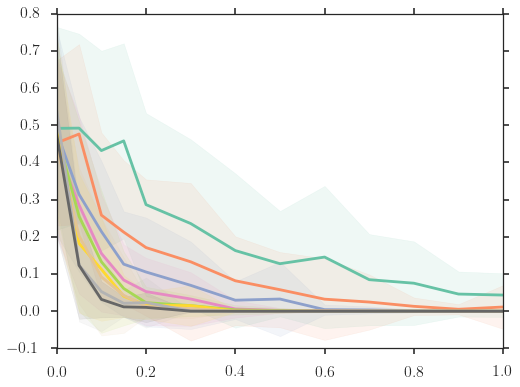

In [4]:
sns.set(palette=sns.color_palette("Set2", 8) + [(0.4, 0.4, 0.4)],
        style='ticks', context='poster')
fig, ax = plt.subplots(figsize=(8, 6))
for A_count, A in enumerate(assembly_sizes):
    curr_handle, = ax.plot(correlations, cpp_cpp_o2o[A_count,:,0])
    ax.fill_between(correlations,
                    cpp_cpp_o2o[A_count,:,0]-cpp_cpp_o2o[A_count,:,1],
                    cpp_cpp_o2o[A_count,:,0]+cpp_cpp_o2o[A_count,:,1],
                    color=curr_handle.get_color(),
                    alpha=0.1)
plt.show()

In [5]:
data_path = '/home/robin/Projects/pop_cch_results/'
filename = '10A_10A_fixcc02_result.h5'

traj = Trajectory(filename=data_path + filename)
traj.f_load(index=-1, load_parameters=0,
            load_results=2, force=True)
traj.v_auto_load = True

assembly_sizes = [[], [2], [3], [4], [5], [6], [7], [8], [9], [10]]

cpp_cpp_fix_cc_02 = np.zeros((len(assembly_sizes),len(assembly_sizes),2))

for A1_count, A1 in enumerate(assembly_sizes):
    for A2_count, A2 in enumerate(assembly_sizes):
        run_count = A1_count * len(assembly_sizes) + A2_count
        run = traj.results['run_{:08d}'.format(run_count)]

        cpp_cpp_fix_cc_02[A1_count][A2_count][0] = run['cpp_cpp_o2o_mean']
        cpp_cpp_fix_cc_02[A1_count][A2_count][1] = run['cpp_cpp_o2o_std']

ValueError: File `/home/robin/Projects/pop_cch_results/10A_10A_fixcc02_result.h5` does not exist.

In [9]:
data_path = '/home/robin/Projects/pop_cch_results/'
filename = '11cc_11cc_fixA5_result.h5'

correlations = [.0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1.]

traj = Trajectory(filename=data_path + filename)
traj.f_load(index=-1, load_parameters=0,
            load_results=2, force=True)
traj.v_auto_load = True

cpp_cpp_fix_A_5 = np.zeros((len(correlations),len(correlations),2))

for cc1_count, cc1 in enumerate(correlations):
    for cc2_count, cc2 in enumerate(correlations):
        run_count = cc1_count * len(correlations) + cc2_count
        run = traj.results['run_{:08d}'.format(run_count)]

        cpp_cpp_fix_A_5[cc1_count][cc2_count][0] = run['cpp_cpp_o2o_mean']
        cpp_cpp_fix_A_5[cc1_count][cc2_count][1] = run['cpp_cpp_o2o_std']

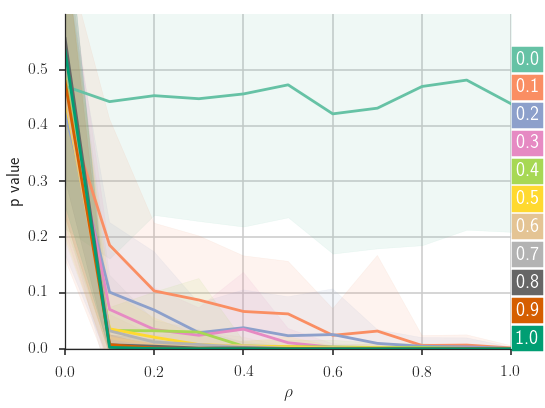

In [35]:
sns.set(palette=sns.color_palette("Set2", 8)+[(0.4,0.4,0.4)]+['r','g'], style='ticks', context='poster')
fig, ax = plt.subplots(figsize=(8,6))

for count, cc in enumerate(correlations):
    curr_handle, = ax.plot(correlations, cpp_cpp_fix_A_5[count,:,0])
    ax.fill_between(correlations, cpp_cpp_fix_A_5[count,:,0]-cpp_cpp_fix_A_5[count,:,1], 
                    cpp_cpp_fix_A_5[count,:,0]+cpp_cpp_fix_A_5[count,:,1], color=curr_handle.get_color(), 
                    alpha=0.1)
    ax.text(1.01, .51-.5/10.*count,
                        '{}'.format(cc),
                        fontweight='bold',
                        backgroundcolor=curr_handle.get_color(),
                        color='w')

ax.set_xlabel(r'$\rho$')
ax.set_ylabel('p value')
ax.set_ylim((0.00,.6))
# ax.set_yscale('log')
ax.grid()
sns.despine()
plt.savefig('/home/robin/Sciebo/Documents/Thesis/Figures/eigenangle_param_scan_o2o_fixA5.png', bbox_inches='tight')